## Imports

In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment
!pip install gym_ple
!pip install -e ./PyGame-Learning-Environment
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ple
    Found existing installation: ple 0.0.1
    Uninstalling ple-0.0.1:
      Successfully uninstalled ple-0.0.1
  Running setup.py develop for ple
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import sys
sys.path.append('/content/PyGame-Learning-Environment')
from ple.games.flappybird import FlappyBird
from ple import PLE
from gym import spaces
import IPython
import numpy as np
import gym
import os
import pyvirtualdisplay
import base64
import warnings
import imageio
from abc import ABC, abstractmethod
warnings.filterwarnings("ignore")


### My imports

In [ ]:
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

### Utility function to display episode

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Utility to evaluate and play video

In [ ]:
def evaluate_run_video(env, agent, max_steps = 100, video_filename = None):
  # reset env
  obs = env.reset()
  print(f"reset: {obs}")

  if video_filename is None: video_filename = '/content/vid.mp4'

  # Evaluation
  with imageio.get_writer(video_filename, fps=24) as video:
    done = False
    total_reward = 0
    for step in range(max_steps):
      if agent is None:
        action = env.action_space.sample()
      else:
        action = agent.select_action(obs, deterministic=True)
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        print(f"done: {next_obs}")
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
  return video_filename

### Utility to build a custom environment

In [ ]:
def build_my_env():
  # observation mapping
  custom_obs_mapping = {0: "player_y_dot",
                        1: 'next_x',
                        2: 'next_y_dist',
                        3: 'next_next_x',
                        4: 'next_next_y_dist'}

  # if we look only one pipe ahead
  if disregard_next_next: custom_obs_mapping = dict(list(custom_obs_mapping.items())[:3])

  # build the env
  env = Game(custom_obs=True,
            force_fps = True,
            custome_observation_map=custom_obs_mapping,
            preprocess=preprocess,
            reward_shaping=reward_shaping)
  return env

### Utility to plot convergance

In [ ]:
def plot_average_metrics(rewards, scores, window_size=100, legends = None, epsilons = None):
  # generate a legend
  if legends is None:
    legends = [f"Run {i + 1}" for i in range(len(rewards))]

  # plot
  plt.figure(figsize=(10, 5))

  # subplot 1 - reward
  ax1 = plt.subplot(2, 1, 1)
  # plot for each case
  for reward, legend in zip(rewards, legends):
      # compute moving average over the window size
      rewards_avg = np.convolve(reward, np.ones(window_size) / window_size, mode='valid')
      ax1.plot(rewards_avg, label=legend)
  ax1.set_title(f'Reward Averaged Over {window_size} Episodes')
  ax1.set_xlabel("Episode (averaged)")
  ax1.set_ylabel("Average Reward")
  ax1.legend(loc="best")
  ax1.grid()

  # optionally plot epsilon
  if epsilons:
    ax2 = ax1.twinx()  # Create a secondary y-axis for epsilon
    for epsilon, label in zip(epsilons, legends):
        ax2.plot(epsilon, linestyle='--', alpha=0.7, label=f"{label} (Epsilon)")
    ax2.set_ylabel("Epsilon")
    ax2.legend(loc="upper left")

  # subplot 2 - score
  ax3 = plt.subplot(2, 1, 2)
  # plot for each case
  for score, legend in zip(scores, legends):
      scores_avg = np.convolve(score, np.ones(window_size) / window_size, mode='valid')
      ax3.plot(scores_avg, label=legend)
  ax3.set_title(f'Score Averaged Over {window_size} Episodes')
  ax3.set_xlabel("Episode (averaged)")
  ax3.set_ylabel("Average Score")
  ax3.legend(loc="best")
  ax3.grid()

  # optionally plot epsilon
  if epsilons:
    ax4 = ax3.twinx()  # Create a secondary y-axis for epsilon
    for epsilon, label in zip(epsilons, legends):
        ax4.plot(epsilon, linestyle='--', alpha=0.7, label=f"{label} (Epsilon)")
    ax4.set_ylabel("Epsilon")
    ax4.legend(loc="upper left")

  plt.subplots_adjust(hspace=0.5)
  plt.show()

### Utility to Test an Agent

In [ ]:
def validate_agent(agent, env, num_episodes, generate_video_every = None, plot_graph=False, window_size=10, vid_path = "/content/"):
  rewards = []
  scores = []
  videos = []

  for episode in range(num_episodes):

    # set video
    video_filename = None

    # check if we need to generate video
    if generate_video_every and (episode + 1) % generate_video_every == 0:
      video_filename = vid_path + f'vid_{episode + 1}.mp4'

    total_reward, score, video_file = agent.run_policy(env, video_filename=video_filename)

    # append results
    rewards.append(total_reward)
    scores.append(score)
    if video_filename: videos.append(video_filename)

  # calcaulte stats
  stats = {
    'average_reward': np.mean(rewards),
    'reward_variance': np.var(rewards),
    'max_reward': np.max(rewards),
    'min_reward': np.min(rewards),
    'average_score': np.mean(scores),
    'score_variance': np.var(scores),
    'max_score': np.max(scores),
    'min_score': np.min(scores),
    'successful_episodes': len(np.where(np.array(scores) > 10)[0])
  }

  # optionally - plot graph
  if plot_graph:
        plot_average_metrics(rewards, scores, window_size)

  return stats, videos

## Environment

### Environment Class

This is the generic env class for our game.






In [ ]:
# to disable the python game window popup
os.environ["SDL_VIDEODRIVER"] = "dummy"

OBSERVATION_MAP = {0: 'player_y',
                   1: "player_vel",
                   2: "next_pipe_dist_to_player",
                   3: "next_pipe_top_y",
                   4: "next_pipe_bottom_y",
                   5: "next_next_pipe_dist_to_player",
                   6: "next_next_pipe_top_y",
                   7: "next_next_pipe_bottom_y",
}

class Game(gym.Env):
    def __init__(self, display_screen=False,
                 force_fps=True,
                 custom_obs=False,
                 pipe_gap=80,
                 custome_observation_map={},
                 preprocess=lambda x: x,
                 reward_shaping=lambda x, y, z: x):

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        game = FlappyBird(pipe_gap=pipe_gap)  # define and initiate the environment
        self.env = PLE(game, fps=30, display_screen=display_screen,
                       force_fps=force_fps)
        self.env.init()
        # list of actions in the environment
        self.actions = self.env.getActionSet()
        # length of actions
        self.action_space = spaces.Discrete(len(self.actions))
        self.custom_obs = custom_obs
        self._observation_map = custome_observation_map if custom_obs else OBSERVATION_MAP
        self.preprocess = preprocess
        self.reward_shaping = reward_shaping
        self.score = 0

    @property
    def observation_space(self):
        return spaces.Box(low=0, high=512, shape=(len(self._observation_map),), dtype=int)

    def _get_rgb(self):
        return self.env.getScreenRGB().transpose(1, 0, 2)

    @property
    def observation_map(self):
        return self._observation_map

    def step(self, action):
        """Take the action chosen and update the reward"""
        reward = self.env.act(self.actions[action])
        if reward < 0:
          reward = -1

        if reward > 0:
          self.score += 1
        state = self.env.getGameState()
        terminal = self.env.game_over()
        reward = self.reward_shaping(reward, terminal, self.env)
        info = {'score':self.score}
        return self.preprocess(np.array(list(state.values())).astype(int)), reward, terminal, info

    def getGameState(self):
        '''
        PLEenv return gamestate as a dictionary. Returns a modified form
        of the gamestate only with the required information to define the state
        '''
        state = self.env.getGameState()
        h_dist = state['next_pipe_dist_to_player']
        v_dist = state['next_pipe_bottom_y'] - state['player_y']
        vel = state['player_vel']

        return ' '.join([str(vel), str(h_dist), str(v_dist)])

    def reset(self):
        """Resets the game to start a new game"""
        self.env.reset_game()
        state = self.env.getGameState()
        self.score = 0
        return self.preprocess(np.array(list(state.values())).astype(int))

    def render(self, mode='human'):
        """Render the game"""
        return self._get_rgb()

    def seed(self, seed):
        rng = np.random.RandomState(seed)
        self.env.rng = rng
        self.env.game.rng = self.env.rng

        self.env.init()

### Pre-Processnig
This is the custom pre-processing function for our game. It prefoms normalization, feature extraction and elimination as explained in the report. The end result is a feature vector of size 3 or 5.

In [ ]:
def preprocess(obs):
  """
  insert your preprocessing code here
  """
  # obs parsing:[player_y, player_y_dot, next_x, next_top, nex_bottom, next_next_x, next_next_top, next_next_bottom]

  # Step 1: Normalize
  # the min and max values for each observation feature are computed
  max_values = np.array([512, 20, 512, 512, 512, 512, 512, 512])
  min_values = np.array([0, -20, 0, 0, 0, 0, 0, 0])

  # normalize
  normalized_obs = (obs - min_values) / (max_values - min_values)

  # Step 2: Compute key features
  # compute y distance between player and center of next and next next pipe
  next_y_dist = ((obs[3] + obs[4]) / 2 - obs[0] + 512) / (512 * 2)
  next_next_y_dist = ((obs[6] + obs[7]) / 2 - obs[0] + 512) / (512 * 2)

  # build the reduced features:
  # [player_y_dot, next_x, next_y_dist, next_next_x, next_next_y_dist]
  obs = [normalized_obs[1], normalized_obs[2], next_y_dist, normalized_obs[5], next_next_y_dist]

  # Step 3: if disregard_next_next:
  global disregard_next_next
  if disregard_next_next:
    obs = obs[:3]

  return obs

### Reward shaping
This function is our custom reward shaping based on the strategy explained in the report.

In [ ]:
def reward_shaping(reward, terminal, env):
  """
  insert your preprocessing code here
  """
  my_reward = 0
  global centering_weight, frame_bonus

  # reward for staying alive, or penalty for crashing
  my_reward += frame_bonus if not terminal else -100.0

  # reward for passing a pipe
  if(reward > 0): my_reward += 10.0

  # reward for centering the bird and the pipe
  state = env.getGameState()
  # compute absolute distance from center
  next_pipe_gap_center = abs((state['next_pipe_top_y'] + state['next_pipe_bottom_y']) / 2 - state['player_y'])
  # normalize
  next_pipe_gap_center = next_pipe_gap_center / 512
  next_pipe_gap_reward = 1 - next_pipe_gap_center
  #print(f"centering:{ centering_weight * next_pipe_gap_reward}")
  # define a weight for this reward

  my_reward += centering_weight * next_pipe_gap_reward

  return my_reward

## Learning Agents

### Abstract Class for Implementing an On-Policy Agent

This is the template class given in the tutorial notebook.

In [ ]:
from abc import ABC, abstractmethod

class OnPolicyAgent(ABC):
    def __init__(self, action_space, observation_space, gamma, learning_rate):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.policy = None  # Placeholder for policy (to be implemented in subclasses)

    @abstractmethod
    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        pass

    @abstractmethod
    def update_policy(self, transition):
        """
        Update the policy based on the current transition.

        Parameters:
        - transition: Data collected from interactions with the environment (tuple of zero or more values such as acion, reward etc...)
        """
        pass

    @abstractmethod
    def train(self, env, num_episodes, log_every):
        """
        Train the agent over a specified number of episodes.

        Parameters:
        - env: The environment to train in
        - num_episodes: Number of training episodes
        """
        pass

    @abstractmethod
    def save_policy(self, file_path):
        """
        Save the current policy to a file.

        Parameters:
        - file_path: Path to the file where the policy should be saved
        """
        pass

    @abstractmethod
    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
        - file_path: Path to the file from which the policy should be loaded
        """
        pass

    @abstractmethod
    def run_policy(self, env):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
        - env: The environment in which to run the policy

        Returns:
        - total_reward: Total reward accumulated in the episode
        """
        pass


### State discretization
Since the environment supplies a continous observation, we need to discretize it to bins before passing to the agant.

In [ ]:
def discretize_observation(observation, bins):
  '''
  args:
  - observation: observation vector of any length, with values normalized [0,1]
  - bins = the number of bins to use per element of the vector - must have at least the same len as observation
  returns:
    the index of the state (int)
  '''

  # discretize each feature according to the bin count - using the fact they are normalized
  discrete_idx = (observation * np.array(bins)).astype(int)
  discrete_idx = np.clip(discrete_idx, 0, np.array(bins) - 1)

  # map to state index
  state = np.ravel_multi_index(discrete_idx, bins)

  return state

### SARSA Agent
This is an implementation of a SARSA agent using some default values.

In [ ]:
class SARSA_agent(OnPolicyAgent):
  def __init__(self, action_space, observation_space, gamma = 0.90, learning_rate = 0.2, epsilon = 0.05, bins = [10] * 5):
      """
      - action_space: The action space of the environment
      - observation_space: The observation space of the environment
      - gamma: Discount factor for future rewards
      - learning_rate: Learning rate for policy updates
      - epsilon: exploration rate for epsilon-greedy policy
      - bins: the discretization strategy to use
      """
      super().__init__(action_space, observation_space, gamma, learning_rate)

      # check there is enough bins
      self.bins = bins
      assert observation_space.shape[0] == len(bins)

      # Handle epsilon (static or decay mode)
      if isinstance(epsilon, list) and len(epsilon) == 3:
        # epsilion decay is on
          self.eps_decay = True
          self.eps_start, self.eps_end, self.decay_episodes = epsilon
          self.decay_rate = (self.eps_start - self.eps_end) / self.decay_episodes
          self.epsilon = self.eps_start
      elif isinstance(epsilon, (int, float)):
        # eps decay is off
          self.eps_decay = False
          self.epsilon = epsilon
      else:
          raise ValueError("Epsilon must be either a float/int or a list of [start, end, episodes].")

      # q-table
      self.policy = np.zeros((np.prod(self.bins), self.action_space.n))

  def select_action(self, state, deterministic=False):
    '''
    Select an epsilon-greedy action.
    - state: discretized state
    - deterministic: Flag indicating whether to use a deterministic policy (default is False)
    Returns:
      action (0 or 1)
    '''
    # if deterministic OR greedy
    if deterministic or np.random.rand() > self.epsilon:
      return np.argmax(self.policy[state])
    # else - eps-greedy exploration
    else:
      return self.action_space.sample()

  def _update_epsilon_decay(self, current_eps):
    # check if we need to decay
    if self.eps_decay:
      # check if end
      if current_eps >= self.decay_episodes:
        self.epsilon = self.eps_end
        # othervise compute the decay
      else:
        self.epsilon = self.eps_start - self.decay_rate * current_eps

  def update_policy(self, transition):
    '''
    update the q-table according to the SARSA update rule:
    Q(s,a) = Q(s,a) + alpha * (reward + gamma * Q(s',a') - Q(s,a))
    - transition: (s, a, s', a', reward)
    '''
    # unpack
    s, a, s_prime, a_prime, reward = transition
    Q = self.policy[s][a]
    Q_prime = self.policy[s_prime][a_prime]

    # update rule
    self.policy[s][a] += self.learning_rate * (reward + self.gamma * Q_prime - Q)

  def train(self, env, num_episodes, log_every, full_log = None, save_on_log = False, save_name = None):
      """
      Train the agent over a specified number of episodes.

      Parameters:
      - env: The environment to train in
      - num_episodes: Number of training episodes
      returns:
        list of rewards and list of scores per episode
      """
      rewards = []
      scores = []
      epsilons = []

      # if full log
      log_file = open(full_log, 'w') if full_log else None

      # loop on episodes
      for episode in range(num_episodes):
        # reset params
        total_reward = 0
        done = False
        # reset env
        obs = env.reset()
        # transform to discrete state
        s = discretize_observation(obs, self.bins)
        # take initial action
        a = self.select_action(s)

        # loop until episode ends
        while not done:
          # preform action and transform to state
          obs_prime, reward, done, info = env.step(a)
          s_prime = discretize_observation(obs_prime, self.bins)

          # _update_epsilon_decay
          self._update_epsilon_decay(episode)
          # select next action
          a_prime = self.select_action(s_prime)

          # update policy (Q-table)
          transition = (s, a, s_prime, a_prime, reward)
          self.update_policy(transition)

          # if full log, log every step
          if log_file:
            log_file.write(
                f"Episode {episode}, Old observation: {[f'{x:.3f}' for x in obs]}, "
                f"Discretized State: {s}, Action: {a}, "
                f"Next Observation: {[f'{x:.3f}' for x in obs_prime]}, "
                f"Next State: {s_prime}, Next Action: {a_prime}, Reward: {reward:.3f}\n"
            )

          # update state
          s = s_prime
          a = a_prime
          obs = obs_prime
          total_reward += reward

        # after episode ends
        rewards.append(total_reward)
        scores.append(info['score'])
        epsilons.append(self.epsilon)

        # print optionally
        if (episode + 1) % log_every == 0:
          avg_reward = np.mean(rewards[-log_every:])
          avg_score = np.mean(scores[-log_every:])
          print(f"Episodes {episode - log_every + 1} to {episode + 1}: Avg Total Reward = {avg_reward}, Avg Score = {avg_score}, Last epsilon = {self.epsilon}")

          # save optionally when logging
          if (save_on_log):
            policy_save_name = save_name + f'_{episode + 1}.npy'
            self.save_policy(policy_save_name)

      # Close log file
      if log_file:
          log_file.close()

      return rewards, scores, epsilons

  def save_policy(self, filepath):
    try:
      np.save(filepath, self.policy)
      print(f"Policy saved successfully to {filepath}")
    except Exception as e:
      print(f"Error saving policy: {e}")

  def load_policy(self, filepath):
    if os.path.exists(filepath):
      try:
          self.policy = np.load(filepath)
          print(f"Policy loaded successfully from {filepath}")
      except Exception as e:
          print(f"Error loading policy: {e}")
    else:
      print(f"File not found: {filepath}")

  def run_policy(self, env, video_filename = None):
    # setup
    obs = env.reset()
    s = discretize_observation(obs, self.bins)
    done = False
    total_reward = 0
    # video
    if video_filename is not None:
      video = imageio.get_writer(video_filename, fps=24)
    # run on frames
    while not done:
      # action
      a_prime = self.select_action(s, deterministic=True)
      obs_prime, reward, done, info = env.step(a_prime)
      # new state
      s_prime = discretize_observation(obs_prime, self.bins)
      # reward and update
      total_reward += reward
      s = s_prime
      # generate video
      if video_filename is not None:
        re = env.render()
        video.append_data(re)
    # close video
    if video_filename is not None:
      video.close()
    # get score
    score = info['score']
    return total_reward, score, video_filename

### Q-learning Agent

In [ ]:
# inherit almost everything
class QLearningAgent(SARSA_agent):
    def __init__(self, action_space, observation_space, gamma=0.90, learning_rate=0.2, epsilon=0.05, bins=[10] * 5):
        # initialization is the same
        super().__init__(action_space, observation_space, gamma, learning_rate, epsilon, bins)

    def update_policy(self, transition):
        # unpackt
        s, a, s_prime, _, reward = transition
        Q = self.policy[s][a]
        Q_max_prime = np.max(self.policy[s_prime])  # Max Q-value for the next state

        # Q-learning update rule
        self.policy[s][a] += self.learning_rate * (reward + self.gamma * Q_max_prime - Q)


## Experimentation


### Baseline Model
The purpose of this section is to train a baseline model using SARSA, to serve as a basline for comparison. See the report for full results of the baseline model.

#### Baseline Env
We begin by defining our custom environent, which makes use of our reward shaping and pre-processing functions. The params of these functions can be adjusted on the fly using global variables (an ugly but useful method).

In the beginning we will use only 3 features by selecting `disregard_next_next = true`.

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
centering_weight = 0.0 # weight for centering
frame_bonus = 0.0 # bonus per frame survived

# build env using util
env = build_my_env()

#### Test Env

In [ ]:
# print obs space
print(f"observation space: {env.observation_space}")
for feautre, des in env.observation_map.items():
  print(f"feautre: {feautre} -> {des}")

observation space: Box(0, 512, (3,), int64)
feautre: 0 -> player_y_dot
feautre: 1 -> next_x
feautre: 2 -> next_y_dist


In [ ]:
video_filename = evaluate_run_video(env, agent = None, max_steps = 100, video_filename = None)
embed_mp4(video_filename)

#### Train Baseline Agent
We create an agent with the discretization params and start training for 10K episodes. Then, we save the policy as the baseline.

In [ ]:
bins = [5, 10, 10]  # Number of bins for each feature
agent = SARSA_agent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.2, epsilon=0.05, bins=bins)

In [ ]:
rewards, scores,_  = agent.train(env, num_episodes=20000, log_every=1000, full_log = None)

In [ ]:
agent.save_policy('/content/baseline_policy.npy')

Policy saved successfully to /content/baseline_policy.npy


#### Evaluate Convergance
Next we can examine the convergance of the training:

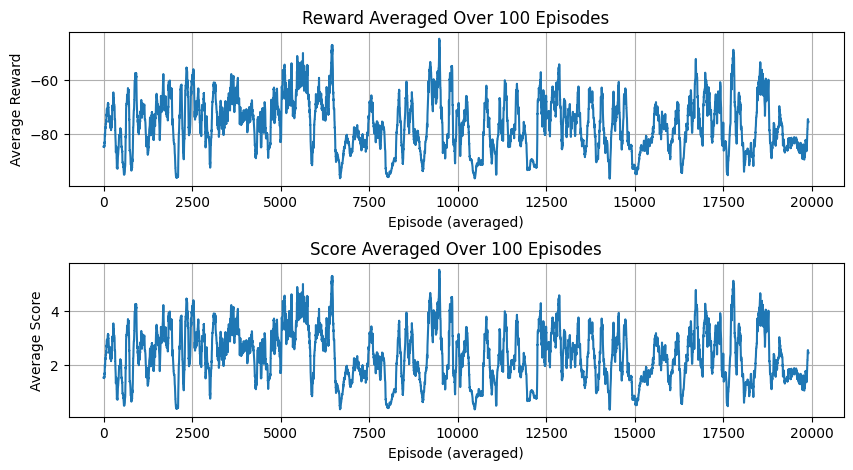

In [ ]:
plot_average_metrics(rewards, scores, window_size=100)

#### Evaluate Policy
Let's look at the metrics:

In [ ]:
stats, _ = validate_agent(agent, env, 100, generate_video_every = None, plot_graph = False, window_size=10)
print(stats)

{'average_reward': -94.9, 'reward_variance': 140.98999999999995, 'max_reward': -40.0, 'min_reward': -100.0, 'average_score': 0.51, 'score_variance': 1.4099000000000002, 'max_score': 6, 'min_score': 0}


### Learning Parameters Optimization

#### Environment
First we build the basic environment for testing:

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
centering_weight = 0.0 # weight for centering
frame_bonus = 0.0 # bonus per frame survived

# build env using util
env = build_my_env()

# binning
bins = [10, 20, 20]

#### Testing - Epsilon binning

In [ ]:
param_configs = [
    {"epsilon": 0.05, "learning_rate": 0.2, "gamma": 0.9},
    {"epsilon": 0.2, "learning_rate": 0.2, "gamma": 0.9},
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.2, "gamma": 0.9},
    {"epsilon": [1.0, 0.00, 10000], "learning_rate": 0.2, "gamma": 0.9},
    {"epsilon": [1.0, 0.00, 15000], "learning_rate": 0.2, "gamma": 0.9}
]

In [ ]:
def test_params(param_configs, episode_count, name):
  for i, config in enumerate(param_configs):
    print(f'\nStarting experiment with epsilon: {config["epsilon"]}, learning_rate: {config["learning_rate"]}, gamma: {config["gamma"]}')

    # build agent and train
    agent = SARSA_agent(env.action_space, env.observation_space, gamma=config["gamma"], learning_rate=config["learning_rate"], epsilon=config["epsilon"], bins=bins)
    rewards, scores, epsilons = agent.train(env, num_episodes=episode_count, log_every=2000, full_log = None)

    # save the policy for this bin configuration
    policy_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/{name}{i}_policy.npy'
    agent.save_policy(policy_filename)
    print(f"Policy saved to {policy_filename}")

    # save the results
    data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/{name}{i}_data'
    np.savez(data_filename, bins=bins, rewards=rewards, scores=scores, epsilons = epsilons)

In [ ]:
test_params(param_configs, 20000, name = 'config_eps_')

#### Analysis

Convergance:

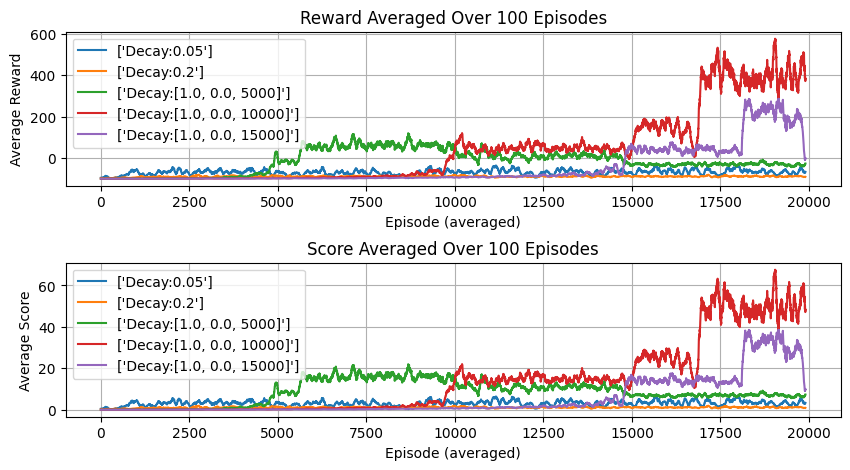

In [ ]:
rewards_list = []
scores_list = []
epsilons = []
legends = []

for i, config in enumerate(param_configs):
  # plot convergance graph
  data = np.load(f'/content/config_eps_{i}_data.npz')
  rewards_list.append(data['rewards'])
  scores_list.append(data['scores'])
  epsilons.append(data["epsilons"])

  # build legend
  legends.append([f"Decay:{config['epsilon']}"])

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

#### Learning Rate and Gamma

In [ ]:
param_configs = [
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.5, "gamma": 0.9},
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.8, "gamma": 0.9},
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.2, "gamma": 0.5},
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.2, "gamma": 0.99},
    {"epsilon": [1.0, 0.00, 5000], "learning_rate": 0.2, "gamma": 0.9},
]

In [ ]:
test_params(param_configs, 10000, 'config_lr_')

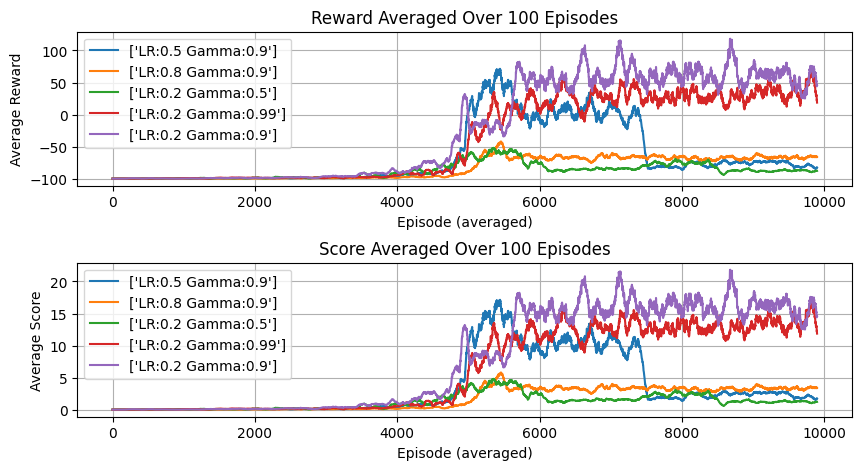

In [ ]:
rewards_list = []
scores_list = []
epsilons = []
legends = []

for i, config in enumerate(param_configs):
  # plot convergance graph
  data = np.load(f'/content/config_lr_{i}_data.npz')
  rewards_list.append(data['rewards'][:10000])
  scores_list.append(data['scores'][:10000])
  epsilons.append(data["epsilons"][:10000])

  # build legend
  legends.append([f"LR:{config['learning_rate']} Gamma:{config['gamma']}"])

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

### Binning Optimization
We will test to see if more bins have an effect on preformance.


#### Environment

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
centering_weight = 0.0 # weight for centering
frame_bonus = 0.0 # bonus per frame survived

# build env using util
env = build_my_env()

#### Testing
These are the tests we will run:

In [ ]:
bin_configs = [
    [2, 5, 10],
    [10, 20, 20],
    [20, 40, 80],
]

In [ ]:
for i, bins in enumerate(bin_configs):
  print(f"\nStarting experiment with bins configuration: {bins}")

  # build agent and train
  agent = SARSA_agent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.1, epsilon=0.1, bins=bins)
  rewards, scores, epsilons = agent.train(env, num_episodes=20000, log_every=2000, full_log = None)

  # save the policy for this bin configuration
  policy_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/bins_{i}_policy.npy'
  agent.save_policy(policy_filename)
  print(f"Policy saved to {policy_filename}")

  # save the results
  data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/bins_{i}_data'
  np.savez(data_filename, bins=bins, rewards=rewards, scores=scores)


Starting experiment with bins configuration: [2, 5, 10]
Episodes 0 to 2000: Avg Total Reward = -81.775, Avg Score = 1.8225, Last epsilon = 0.1
Episodes 2000 to 4000: Avg Total Reward = -85.055, Avg Score = 1.4945, Last epsilon = 0.1
Episodes 4000 to 6000: Avg Total Reward = -86.04, Avg Score = 1.396, Last epsilon = 0.1
Episodes 6000 to 8000: Avg Total Reward = -84.275, Avg Score = 1.5725, Last epsilon = 0.1
Episodes 8000 to 10000: Avg Total Reward = -82.265, Avg Score = 1.7735, Last epsilon = 0.1
Episodes 10000 to 12000: Avg Total Reward = -82.575, Avg Score = 1.7425, Last epsilon = 0.1
Episodes 12000 to 14000: Avg Total Reward = -86.175, Avg Score = 1.3825, Last epsilon = 0.1
Episodes 14000 to 16000: Avg Total Reward = -84.675, Avg Score = 1.5325, Last epsilon = 0.1
Episodes 16000 to 18000: Avg Total Reward = -82.935, Avg Score = 1.7065, Last epsilon = 0.1
Episodes 18000 to 20000: Avg Total Reward = -83.98, Avg Score = 1.602, Last epsilon = 0.1
Policy saved successfully to /content/d

#### Analysis

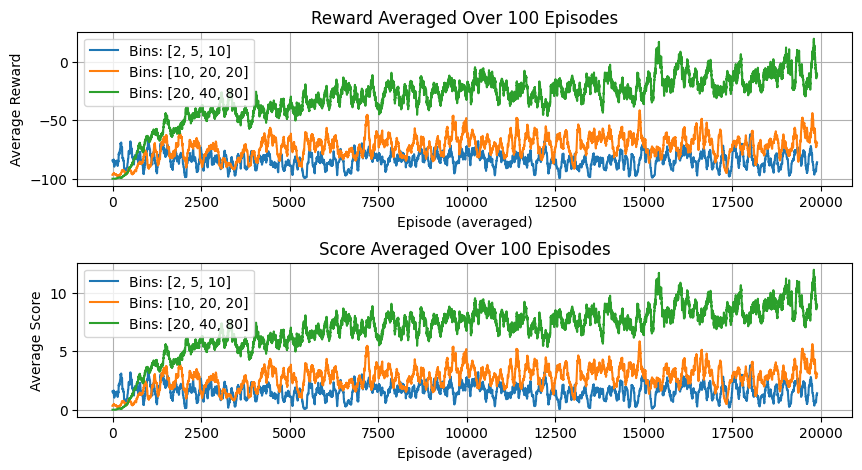

In [ ]:
rewards_list = []
scores_list = []
legends = []

for i, bins in enumerate(bin_configs):
  data = np.load(f'/content/bins_{i}_data.npz')
  rewards_list.append(data['rewards'])
  scores_list.append(data['scores'])
  legends.append(f'Bins: {bins}')

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

### Reward optimization


#### Centering weight
We will investigate the effect of the centering weight on the result.

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
frame_bonus = 0.0 # bonus per frame survived
# build env using util
env = build_my_env()
# bins
bins = [10, 20, 20]

In [ ]:
centering_weights = [0, 0.1, 0.5, 1, 5]

In [ ]:
for i, cw in enumerate(centering_weights):
  print(f"\nStarting experiment with centering weight: {cw}")
  # weight for centering
  centering_weight = cw

  # build agent and train
  agent = SARSA_agent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.2, epsilon=[1.0, 0, 5000], bins=bins)
  rewards, scores, epsilons = agent.train(env, num_episodes=10000, log_every=2000, full_log = None)

  # save the policy for this  configuration
  policy_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/weight_fine_{cw}_policy.npy'
  agent.save_policy(policy_filename)
  print(f"Policy saved to {policy_filename}")

  # save the results
  data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/weight_fine_{cw}_data'
  np.savez(data_filename, bins=bins, rewards=rewards, scores=scores, centering_weight=cw, epsilons = epsilons)


Starting experiment with centering weight: 0
Episodes 0 to 2000: Avg Total Reward = -99.44, Avg Score = 0.056, Last epsilon = 0.6002
Episodes 2000 to 4000: Avg Total Reward = -95.39, Avg Score = 0.461, Last epsilon = 0.20019999999999993
Episodes 4000 to 6000: Avg Total Reward = 24.08, Avg Score = 12.408, Last epsilon = 0
Episodes 6000 to 8000: Avg Total Reward = 97.65, Avg Score = 19.765, Last epsilon = 0
Episodes 8000 to 10000: Avg Total Reward = 26.435, Avg Score = 12.6435, Last epsilon = 0
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/weight_fine_0_policy.npy
Policy saved to /content/drive/MyDrive/Colab Notebooks/RL/weight_fine_0_policy.npy

Starting experiment with centering weight: 0.1
Episodes 0 to 2000: Avg Total Reward = -94.49120039062498, Avg Score = 0.059, Last epsilon = 0.6002
Episodes 2000 to 4000: Avg Total Reward = -89.30115117187499, Avg Score = 0.4365, Last epsilon = 0.20019999999999993
Episodes 4000 to 6000: Avg Total Reward = -22.83493515624

And the result analysis:

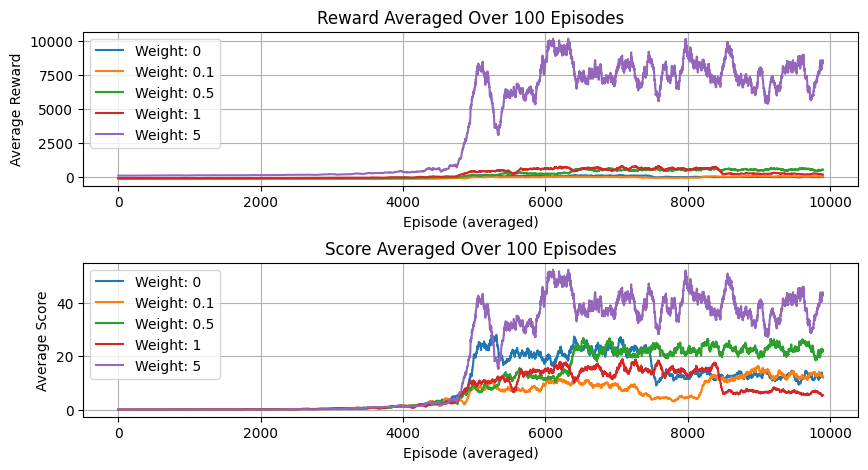

In [ ]:
rewards_list = []
scores_list = []
legends = []

for i, weight in enumerate((centering_weights)):
  data = np.load(f'/content/weight_fine_{weight}_data.npz')
  rewards_list.append(data['rewards'])
  scores_list.append(data['scores'])
  legends.append(f'Weight: {weight}')

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

#### Frame Survival

In [ ]:
survival_bonuses = [0.01, 0.1, 1, 5]
centering_weight = 0

In [ ]:
# try survival bonus
for i, fb in enumerate(survival_bonuses):
  # setup
  print(f"\nStarting experiment with frame bonus: {fb}")
  frame_bonus = fb

  # build agent and train
  agent = SARSA_agent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.2, epsilon=[1.0, 0, 5000], bins=bins)
  rewards, scores, epsilons = agent.train(env, num_episodes=10000, log_every=2000, full_log = None)

  # save the policy for this  configuration
  policy_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/fb_{fb}_policy.npy'
  agent.save_policy(policy_filename)
  print(f"Policy saved to {policy_filename}")

  # save the results
  data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/fb_{fb}_data'
  np.savez(data_filename, bins=bins, rewards=rewards, scores=scores, frame_bonus=fb, epsilons = epsilons)


Starting experiment with frame bonus: 0.01
Episodes 0 to 2000: Avg Total Reward = -98.90912000000003, Avg Score = 0.053, Last epsilon = 0.6002
Episodes 2000 to 4000: Avg Total Reward = -94.77838, Avg Score = 0.45, Last epsilon = 0.20019999999999993
Episodes 4000 to 6000: Avg Total Reward = 23.703534999998315, Avg Score = 11.868, Last epsilon = 0
Episodes 6000 to 8000: Avg Total Reward = 182.72754999999475, Avg Score = 27.19, Last epsilon = 0
Episodes 8000 to 10000: Avg Total Reward = 234.3218149999933, Avg Score = 32.162, Last epsilon = 0
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/fb_0.01_policy.npy
Policy saved to /content/drive/MyDrive/Colab Notebooks/RL/fb_0.01_policy.npy

Starting experiment with frame bonus: 0.1
Episodes 0 to 2000: Avg Total Reward = -93.74240000000002, Avg Score = 0.0605, Last epsilon = 0.6002
Episodes 2000 to 4000: Avg Total Reward = -88.13475, Avg Score = 0.4615, Last epsilon = 0.20019999999999993
Episodes 4000 to 6000: Avg Total Re

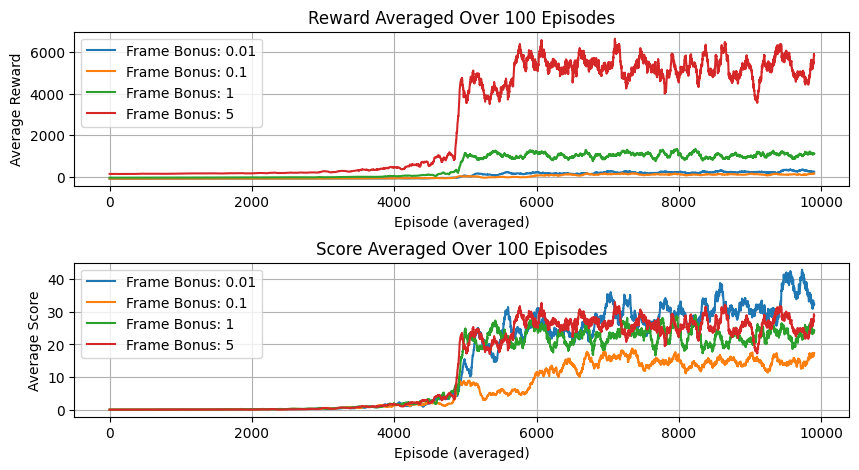

In [ ]:
rewards_list = []
scores_list = []
legends = []

for i, fb in enumerate((survival_bonuses)):
  data = np.load(f'/content/fb_{fb}_data.npz')
  rewards_list.append(data['rewards'])
  scores_list.append(data['scores'])
  legends.append(f'Frame Bonus: {fb}')

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

### Agent Comaprison

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
frame_bonus = 0.0 # bonus per frame survived
centering_weight = 0.0 # centering bonus

# build env using util
env = build_my_env()

# bins
bins = [10, 20, 20]

In [ ]:
sarsa_agent = SARSA_agent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.2, epsilon=[1.0, 0, 5000], bins=bins)
q_agent = QLearningAgent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.2, epsilon=[1.0, 0, 5000], bins=bins)
agents = [sarsa_agent, q_agent]

In [ ]:
for i, agent in enumerate(agents):
  agent_name = type(agent).__name__
  print(f"\nStarting experiment with agent: {agent_name}")

  # build agent and train
  rewards, scores, epsilons = agent.train(env, num_episodes=20000, log_every=2000, full_log = None)

  # save the policy for this  configuration
  policy_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/agents_{agent_name}_policy.npy'
  agent.save_policy(policy_filename)
  print(f"Policy saved to {policy_filename}")

  # save the results
  data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/agents_{agent_name}_data'
  np.savez(data_filename, bins=bins, rewards=rewards, scores=scores, epsilons = epsilons)


Starting experiment with agent: QLearningAgent
Episodes 0 to 2000: Avg Total Reward = -99.19, Avg Score = 0.081, Last epsilon = 0.6002
Episodes 2000 to 4000: Avg Total Reward = -96.28, Avg Score = 0.372, Last epsilon = 0.20019999999999993
Episodes 4000 to 6000: Avg Total Reward = 111.625, Avg Score = 21.1625, Last epsilon = 0
Episodes 6000 to 8000: Avg Total Reward = 237.75, Avg Score = 33.775, Last epsilon = 0
Episodes 8000 to 10000: Avg Total Reward = -26.72, Avg Score = 7.328, Last epsilon = 0
Episodes 10000 to 12000: Avg Total Reward = -22.355, Avg Score = 7.7645, Last epsilon = 0
Episodes 12000 to 14000: Avg Total Reward = -20.145, Avg Score = 7.9855, Last epsilon = 0
Episodes 14000 to 16000: Avg Total Reward = -23.405, Avg Score = 7.6595, Last epsilon = 0
Episodes 16000 to 18000: Avg Total Reward = -26.055, Avg Score = 7.3945, Last epsilon = 0
Episodes 18000 to 20000: Avg Total Reward = 6.345, Avg Score = 10.6345, Last epsilon = 0
Policy saved successfully to /content/drive/MyDr

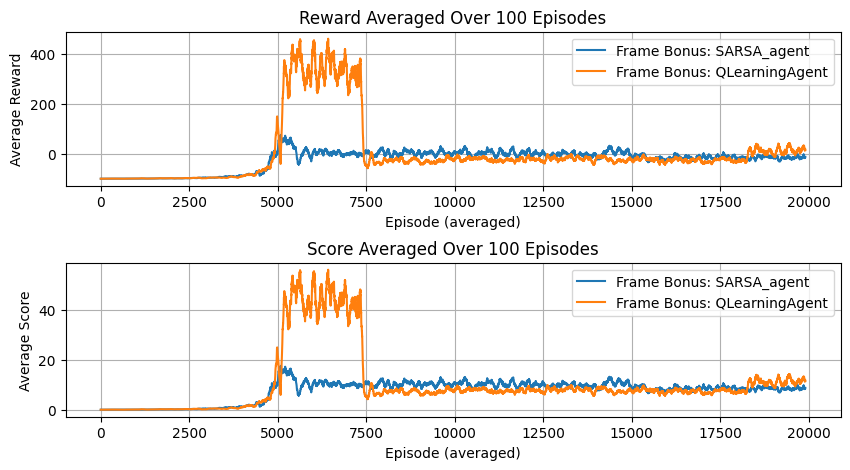

In [ ]:
rewards_list = []
scores_list = []
legends = []

for i, agent in enumerate((agents)):
  agent_name = type(agent).__name__

  data = np.load(f'/content/agents_{agent_name}_data.npz')
  rewards_list.append(data['rewards'])
  scores_list.append(data['scores'])
  legends.append(f'Frame Bonus: {agent_name}')

plot_average_metrics(rewards_list, scores_list, window_size = 100, legend=legends)

## Training the optimal agent

### Training

In [ ]:
# Environ Params
disregard_next_next = True # should we look only 1 pipe ahead
# reward params
frame_bonus = 0.01 # bonus per frame survived
centering_weight = 0.1 # centering bonus

# build env using util
env = build_my_env()

# bins
bins = [10, 40, 40]

# agnet
q_agent = QLearningAgent(env.action_space, env.observation_space, gamma=0.9, learning_rate=0.15, epsilon=[1.0, 0, 5000], bins=bins)
agent_name = 'q_agent'

# path
save_path = "/content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/"

# training params
num_episodes = 10000
validation_every = 1000

In [ ]:
rewards, scores, epsilons = q_agent.train(env,
                                          num_episodes = num_episodes,
                                          log_every=validation_every,
                                          full_log = None, save_on_log = True, save_name = save_path + 'q_learn')

data_filename = f'/content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/q_learning_1_data.npz'
np.savez(data_filename, bins=bins, rewards=rewards, scores=scores, epsilons = epsilons)

Episodes 0 to 1000: Avg Total Reward = -53.89312335937501, Avg Score = 0.006, Last epsilon = 0.8002
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/q_learn_1000.npy
Episodes 1000 to 2000: Avg Total Reward = -50.829867500000006, Avg Score = 0.016, Last epsilon = 0.6002
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/q_learn_2000.npy
Episodes 2000 to 3000: Avg Total Reward = -41.52855929687501, Avg Score = 0.157, Last epsilon = 0.4002
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/q_learn_3000.npy
Episodes 3000 to 4000: Avg Total Reward = 1.1914459374999378, Avg Score = 1.113, Last epsilon = 0.20019999999999993
Policy saved successfully to /content/drive/MyDrive/Colab Notebooks/RL/optimal_policy/q_learn_4000.npy
Episodes 4000 to 5000: Avg Total Reward = 327.2898261718798, Avg Score = 8.127, Last epsilon = 0.00019999999999997797
Policy saved successfully to /content/drive/MyD

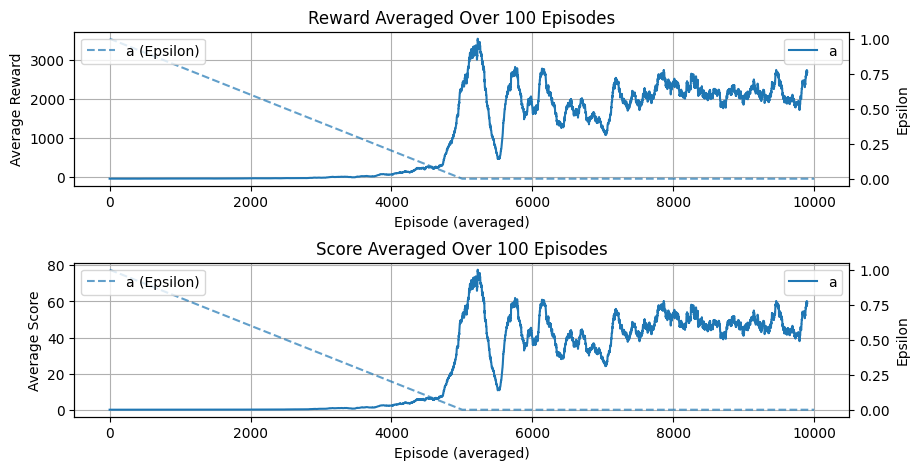

In [ ]:
# plot convergance
legends = ['a']
plot_average_metrics([rewards], [scores], window_size = 100, legends=legends, epsilons = [epsilons])

### Convergance Simualtion
Add video of convergance of the selected model

Validation after 1000 episodes:

In [ ]:
embed_mp4('/content/q_learn_1000_vid_100.mp4')

After 5K episodes:

In [ ]:
embed_mp4('/content/q_learn_5000_vid_100.mp4')

After 10K episodes:

In [ ]:
embed_mp4('/content/q_learn_10000_vid_100.mp4')

### Validation

In [ ]:
validation_episodes = range(validation_every, num_episodes+1, validation_every)
validation_results = {}
videos = {}

for episode in validation_episodes:
    # load the saved policy
    policy_filename = f'/content/q_learn_{episode}.npy'
    #print(f"Loading policy from: {policy_filename}")
    q_agent.load_policy(policy_filename)

    # validate the loaded policy
    #print(f"Validating policy saved at episode {episode}...")
    vid_name = f'/content/q_learn_{episode}_'
    stats, video = validate_agent(q_agent, env, num_episodes=100, generate_video_every=100, plot_graph=False, vid_path = vid_name)

    # Store validation stats
    validation_results[episode] = stats
    videos[episode] = video
    print(f"Validation results for episode {episode}: {stats}")

# Compare validation results
print("\nComparison of Validation Results:")
for episode, stats in validation_results.items():
    print(f"Episode {episode}: Avg Reward = {stats['average_reward']}, Avg Score = {stats['average_score']}")


# dump
with open("/content/q_learn_valid_data.json", "wb") as file:
    pickle.dump(validation_results, file)

Policy loaded successfully from /content/q_learn_1000.npy
Validation results for episode 1000: {'average_reward': -38.25702265625002, 'reward_variance': 103.74343140294137, 'max_reward': -21.332734375, 'min_reward': -60.40937499999999, 'average_score': 0.27, 'score_variance': 0.1971, 'max_score': 1, 'min_score': 0, 'successful_episodes': 0}
Policy loaded successfully from /content/q_learn_2000.npy
Validation results for episode 2000: {'average_reward': 92.22214140624953, 'reward_variance': 21954.011125339697, 'max_reward': 701.2303124999953, 'min_reward': -45.46421875000003, 'average_score': 2.93, 'score_variance': 10.205100000000002, 'max_score': 16, 'min_score': 0, 'successful_episodes': 3}
Policy loaded successfully from /content/q_learn_3000.npy
Validation results for episode 3000: {'average_reward': 136.13671171874932, 'reward_variance': 21179.24992214645, 'max_reward': 657.2424218749956, 'min_reward': 1.0559375000001268, 'average_score': 3.97, 'score_variance': 9.949099999999998,

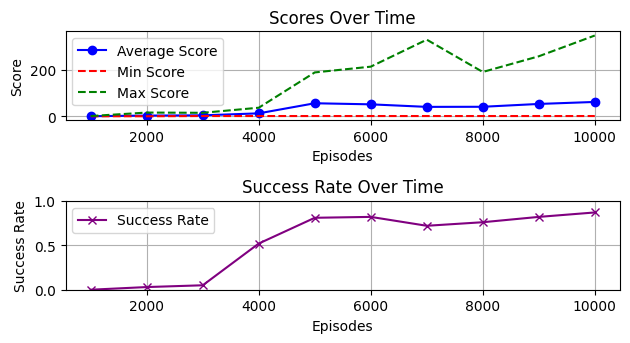

In [ ]:
episodes = list(validation_results.keys())
average_scores = [validation_results[ep]['average_score'] for ep in episodes]
min_scores = [validation_results[ep]['min_score'] for ep in episodes]
max_scores = [validation_results[ep]['max_score'] for ep in episodes]
success_rates = [validation_results[ep]['successful_episodes'] / 100 for ep in episodes]

# Plot Average Score, Min/Max Scores
plt.subplot(3, 1, 1)
plt.plot(episodes, average_scores, label="Average Score", color='blue', marker='o')
plt.plot(episodes, min_scores, label="Min Score", color='red', linestyle='--')
plt.plot(episodes, max_scores, label="Max Score", color='green', linestyle='--')
plt.title("Scores Over Time")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(episodes, success_rates, label="Success Rate", color='purple', marker='x')
plt.title("Success Rate Over Time")
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.ylim(0, 1)  # Set the vertical axis to be between 0 and 1
plt.legend(loc="best")
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()